# Impor Library

In [139]:
import numbers
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

pd.set_option("display.max_columns", 100)

# Persiapkan Data

In [2]:
csv_filename = "loan_data_2007_2014.csv"
feather_filename = "loan_data_2007_2014.feather"

## Membaca Data
Baca data berformat `.csv` setelah itu simpan ke dalam bentuk `.feather`

In [3]:
if not os.path.exists(feather_filename):
    # Baca melalui csv
    df = pd.read_csv("loan_data_2007_2014.csv")

    # Ubah ke feather
    df.to_feather("loan_data_2007_2014.feather")

## Pindah ke Ekstensi Feather
Perpindahan ekstensi dimaksudkan untuk mempercepat proses membaca file. Dibutuhkan waktu sekitar 17 detik untuk membaca file `.csv` sedangkan untuk file `.feather` hanya dibutuhkan waktu sekitar 3 detik

In [4]:
raw_df = pd.read_feather(feather_filename)

## Melihat Sampel Data
Kita perlu mengetahui seperti apa nilai yang terdapat pada semua kolom

In [5]:
raw_df.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,None,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,None,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,None,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,None,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,None,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,None,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,None,Jan-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-96,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Melihat Info Data
Rincian mengenai data perlu diperhatikan untuk mengetahui tipe dan jumlah missing value dalam setiap kolom.

In [6]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

# Menghilangkan Kolom yang Tidak Dipakai

## Menghapus Kolom Tanpa Nama
Terlihat kolom tanpa nama `Unnammed: 0` berada pada data, biasanya disebabkan karena lupa memberikan argumen `index=False` ketika hendak menyimpan data. Oleh karena itu kita akan menghapus kolom tersebut.

In [247]:
# Hapus kolom tanpa nama
inter_df = raw_df.drop(columns=["Unnamed: 0"]).copy()
inter_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,None,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,None,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,None,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,None,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,None,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,None,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,None,Jan-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-96,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Menghapus Kolom dengan Missing Value Tinggi

In [284]:
# Mendeteksi kolom dengan nilai NaN tinggi
col_na_rate = inter_df.isna().mean().sort_values(ascending=False)
col_na_rate

mths_since_last_record         0.865666
mths_since_last_major_derog    0.787739
desc                           0.729815
mths_since_last_delinq         0.536906
next_pymnt_d                   0.487286
tot_cur_bal                    0.150715
tot_coll_amt                   0.150715
total_rev_hi_lim               0.150715
emp_title                      0.059166
emp_length                     0.045054
last_pymnt_d                   0.000806
revol_util                     0.000729
collections_12_mths_ex_med     0.000311
last_credit_pull_d             0.000090
inq_last_6mths                 0.000062
open_acc                       0.000062
acc_now_delinq                 0.000062
total_acc                      0.000062
delinq_2yrs                    0.000062
earliest_cr_line               0.000062
pub_rec                        0.000062
title                          0.000043
annual_inc                     0.000009
total_rec_int                  0.000000
total_rec_late_fee             0.000000


In [249]:
na_limit = 1
excluded_col_na = col_na_rate[col_na_rate >= na_limit].index.to_list()
excluded_col_na

['inq_last_12m',
 'verification_status_joint',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'dti_joint',
 'total_bal_il',
 'annual_inc_joint',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl']

In [250]:
inter_df = inter_df.drop(columns=excluded_col_na, errors="ignore").copy()
inter_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,None,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,None,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,None,Sep-13,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,None,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,None,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,None,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,None,Jan-15,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-96,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN


## Menghapus Data dengan Kardinalitas Maksimal dan Minimal
Data dengan `tingkat kardinalitas atau keberagaman maksimal` mengakibatkan setiap baris data menjadi berbeda sedangkan `tingkat kardinalitas minimal` mengakibatkan setiap baris data menjadi sama semua.

In [251]:
max_cardinality = len(inter_df)
min_cardinality = 1

cardinality_col = inter_df.nunique().sort_values(ascending=False)
cardinality_col

id                             466285
member_id                      466285
url                            466285
total_pymnt                    351609
total_pymnt_inv                347659
total_rec_int                  270249
tot_cur_bal                    220690
emp_title                      205475
last_pymnt_amnt                198194
total_rec_prncp                172713
out_prncp_inv                  141189
out_prncp                      135665
desc                           124436
title                           63099
revol_bal                       58142
installment                     55622
annual_inc                      31901
recoveries                      22773
collection_recovery_fee         20275
total_rev_hi_lim                14612
funded_amnt_inv                  9854
tot_coll_amt                     6321
total_rec_late_fee               5808
dti                              3997
funded_amnt                      1354
loan_amnt                        1352
revol_util  

In [252]:
has_min_cardi = (cardinality_col == min_cardinality)
has_max_cardi = (cardinality_col == max_cardinality)

exclude_col_cardinal = cardinality_col[has_min_cardi | has_max_cardi].index.to_list()
exclude_col_cardinal

['id', 'member_id', 'url', 'policy_code', 'application_type']

In [253]:
inter_df = inter_df.drop(columns=exclude_col_cardinal, errors="ignore").copy()
inter_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,None,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,None,Jan-16,0.0,NaN,0.0,NaN,NaN,NaN
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,None,Sep-13,0.0,NaN,0.0,NaN,NaN,NaN
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,None,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,None,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,None,Jan-16,0.0,NaN,0.0,NaN,NaN,NaN
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,None,Jan-15,0.0,NaN,0.0,NaN,NaN,NaN
4,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-96,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,NaN,0.0,NaN,NaN,NaN


## Info Data Saat Ini

In [254]:
inter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 52 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    466285 non-null  int64  
 1   funded_amnt                  466285 non-null  int64  
 2   funded_amnt_inv              466285 non-null  float64
 3   term                         466285 non-null  object 
 4   int_rate                     466285 non-null  float64
 5   installment                  466285 non-null  float64
 6   grade                        466285 non-null  object 
 7   sub_grade                    466285 non-null  object 
 8   emp_title                    438697 non-null  object 
 9   emp_length                   445277 non-null  object 
 10  home_ownership               466285 non-null  object 
 11  annual_inc                   466281 non-null  float64
 12  verification_status          466285 non-null  object 
 13 

# EDA

In [255]:
title_font = dict(size=20, weight="bold")

def plot_count(df, y, title, **sns_kwargs):
    value_counts = df[y].value_counts()
    percentage = value_counts / value_counts.sum()
    percentage = percentage.apply("{:.2%}".format)

    plt.figure(figsize=(14, 10))
    plt.title(title, fontdict=title_font)
    sns.countplot(data=df, y=y, order=value_counts.index, **sns_kwargs)
    plt.ylabel("")
    plt.show()

    print(percentage)


def plot_distribution(df, x, title, **sns_kwargs):
    plt.figure(figsize=(14, 10))
    plt.title(title, fontdict=title_font)
    sns.histplot(data=df, x=x, kde=True, **sns_kwargs)
    plt.ylabel("")
    plt.show()


def plot_boxplot(df, x, y, title, **sns_kwargs):
    plt.figure(figsize=(14, 10))
    plt.title(title, fontdict=title_font)
    sns.boxplot(data=df, x=x, y=y, **sns_kwargs)
    plt.ylabel("")
    plt.show()

## Status Pinjaman
Sebagian besar pinjaman berada dalam status "sedang berjalan". Pada tingkat keberhasilan, pinjaman yang berhasil dibayarkan kembali memiliki rasio yang lebih tinggi ketimbang pinjaman yang terlambat.

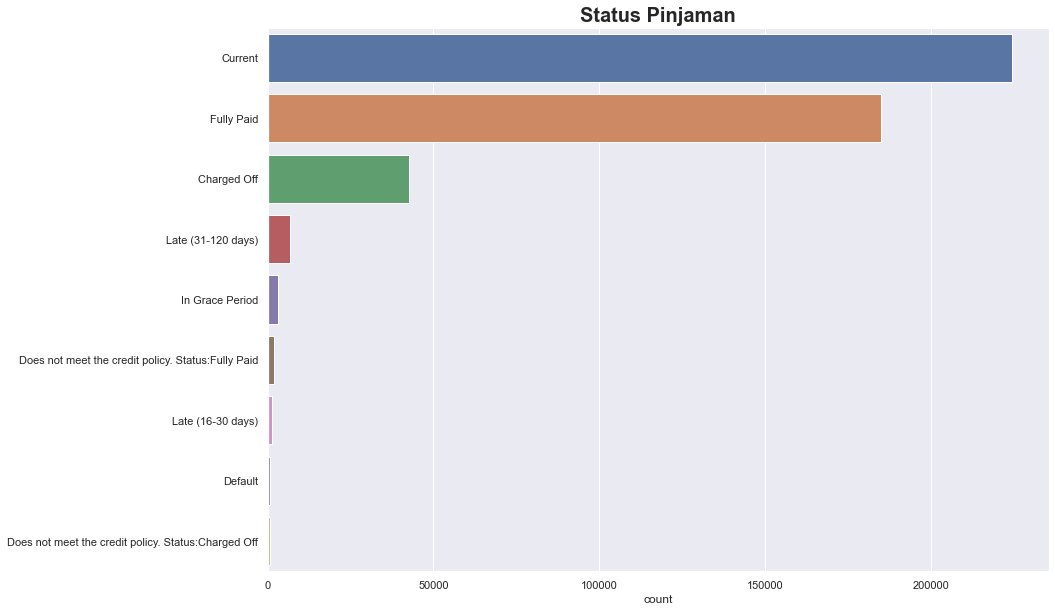

Current                                                48.09%
Fully Paid                                             39.62%
Charged Off                                             9.11%
Late (31-120 days)                                      1.48%
In Grace Period                                         0.67%
Does not meet the credit policy. Status:Fully Paid      0.43%
Late (16-30 days)                                       0.26%
Default                                                 0.18%
Does not meet the credit policy. Status:Charged Off     0.16%
Name: loan_status, dtype: object


In [222]:
plot_count(inter_df, y="loan_status", title="Status Pinjaman")

## Tujuan Mengambil Pinjaman
Lebih dari setengah peminjam memiliki tujuan untuk menutup pinjaman sebelumnya. Apabila dilihat dari jenisnya, tujuan untuk konsumsi lebih banyak daripada tujuan untuk bisnis, renovasi dan pendidikan.

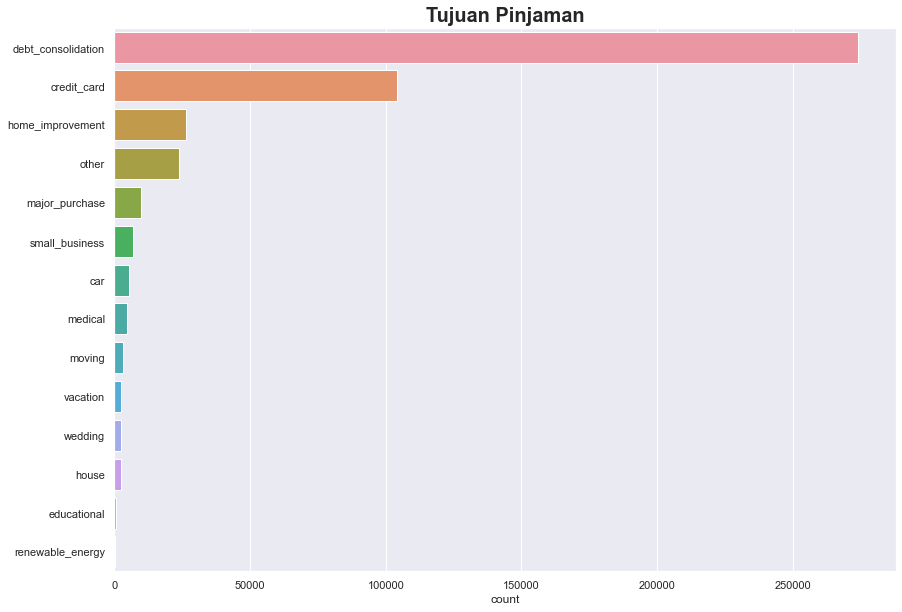

debt_consolidation    58.80%
credit_card           22.34%
home_improvement       5.69%
other                  5.08%
major_purchase         2.11%
small_business         1.50%
car                    1.16%
medical                0.99%
moving                 0.64%
vacation               0.53%
wedding                0.50%
house                  0.49%
educational            0.09%
renewable_energy       0.08%
Name: purpose, dtype: object


In [223]:
plot_count(inter_df, y="purpose", title="Tujuan Pinjaman")

## Negara Asal Peminjam
Peminjam sebagian besar berasal dari negara Kanada.


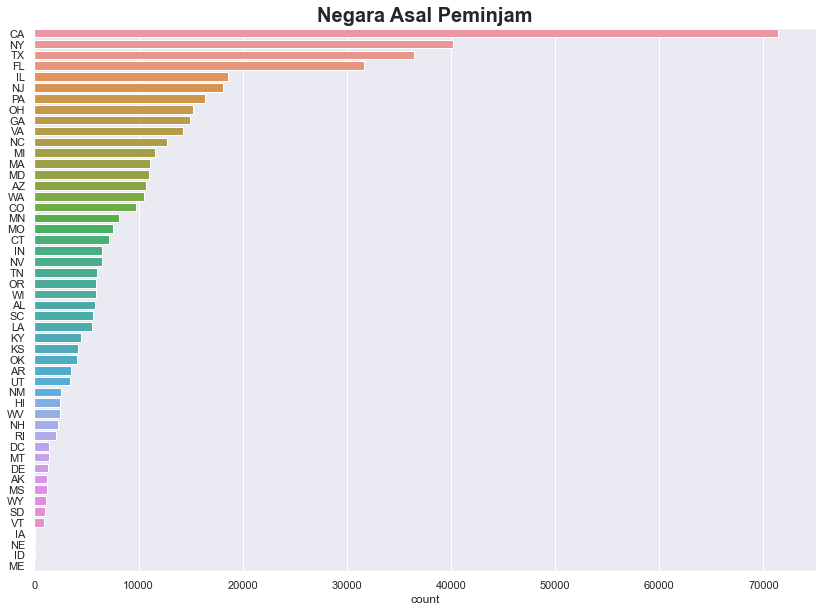

CA    15.32%
NY     8.63%
TX     7.81%
FL     6.78%
IL     3.99%
NJ     3.87%
PA     3.52%
OH     3.27%
GA     3.21%
VA     3.05%
NC     2.72%
MI     2.48%
MA     2.37%
MD     2.35%
AZ     2.30%
WA     2.26%
CO     2.09%
MN     1.75%
MO     1.61%
CT     1.54%
IN     1.40%
NV     1.40%
TN     1.28%
OR     1.28%
WI     1.27%
AL     1.26%
SC     1.20%
LA     1.18%
KY     0.95%
KS     0.90%
OK     0.88%
AR     0.75%
UT     0.74%
NM     0.56%
HI     0.53%
WV     0.52%
NH     0.48%
RI     0.44%
DC     0.31%
MT     0.30%
DE     0.27%
AK     0.27%
MS     0.26%
WY     0.24%
SD     0.21%
VT     0.19%
IA     0.00%
NE     0.00%
ID     0.00%
ME     0.00%
Name: addr_state, dtype: object


In [244]:
plot_count(df=inter_df, y="addr_state", title="Negara Asal Peminjam")

## Jumlah Pinjaman
Rata-rata jumlah pinjaman terbanyak berada pada status `dalam masa tenggang`. Dari perbandingan status pinjaman, rata-rata jumlah pinjaman berstatus `terlambat membayar` lebih besar ketimbang pinjaman berstatus `berhasil membayar`.

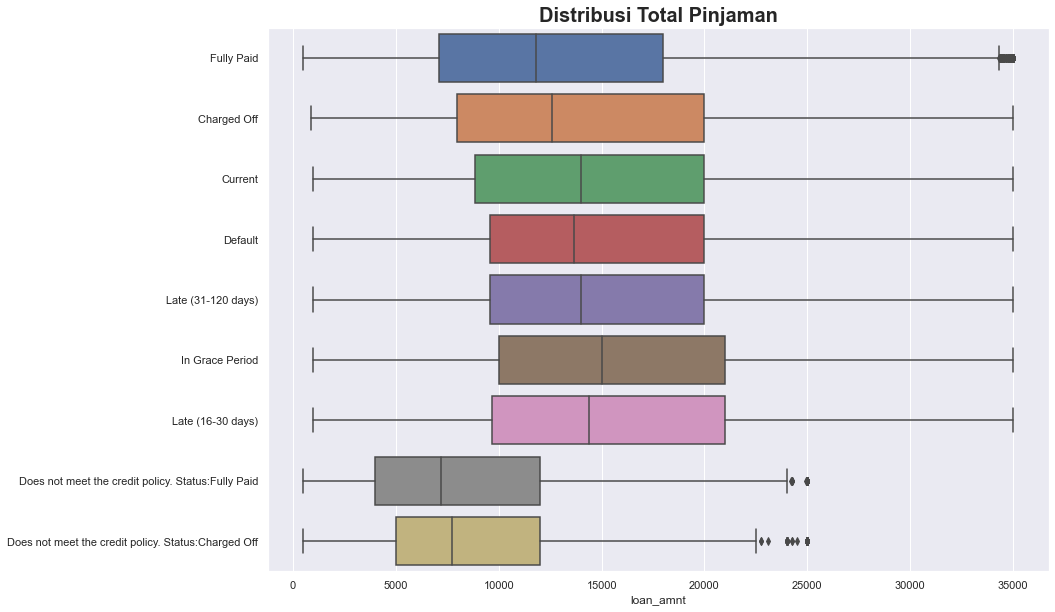

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,42475.0,14518.758682,8373.184813,900.0,8000.0,12600.0,20000.0,35000.0
Current,224226.0,15177.366474,8420.944275,1000.0,8875.0,14000.0,20000.0,35000.0
Default,832.0,15284.885817,8311.439119,1000.0,9600.0,13675.0,20000.0,35000.0
Does not meet the credit policy. Status:Charged Off,761.0,9527.233903,6404.598723,500.0,5000.0,7750.0,12000.0,25000.0
Does not meet the credit policy. Status:Fully Paid,1988.0,8853.231891,6163.442950,500.0,4000.0,7200.0,12000.0,25000.0
Fully Paid,184739.0,13214.394226,7949.030252,500.0,7125.0,11800.0,18000.0,35000.0
In Grace Period,3146.0,16128.289892,8550.986001,1000.0,10000.0,15000.0,21000.0,35000.0
Late (16-30 days),1218.0,15800.779967,8737.787075,1000.0,9687.5,14400.0,21000.0,35000.0
Late (31-120 days),6900.0,15553.757246,8396.213429,1000.0,9600.0,14000.0,20000.0,35000.0


In [240]:
x, y = "loan_amnt", "loan_status"
plot_boxplot(df=inter_df, x=x, y=y, title="Distribusi Total Pinjaman")
inter_df.groupby(y)[x].describe()

## Total Pembayaran yang Diterima
Tampak jelas apabila total pembayaran terbanyak berada pada pinjaman yang berstatus `sudah dibayar penuh`.

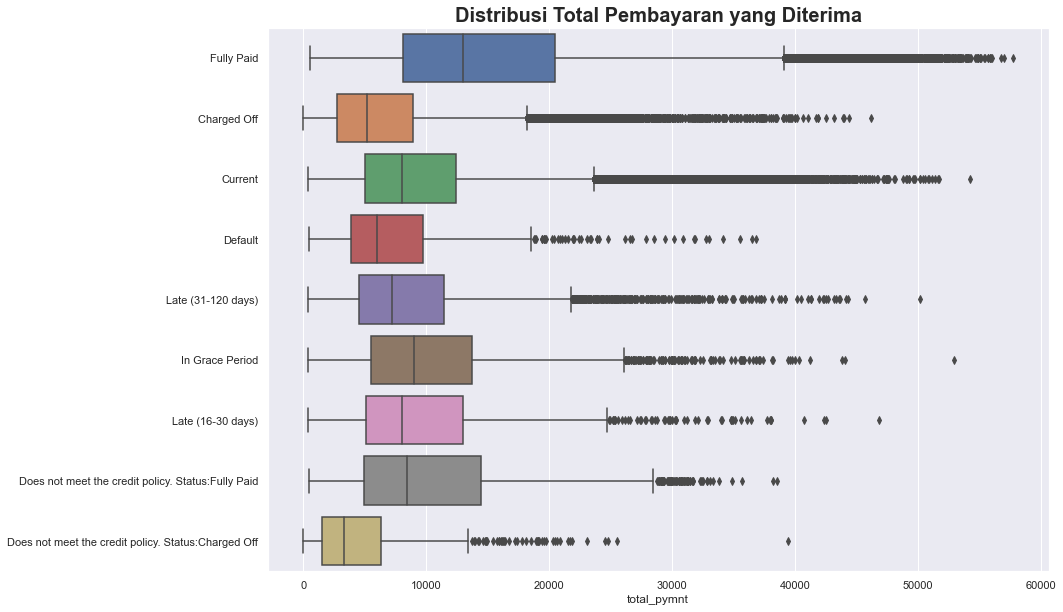

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,42475.0,6657.338290,5449.436828,0.00,2773.445000,5164.780000,8941.5400,46199.44000
Current,224226.0,9591.120804,6327.400904,394.13,5043.680000,8017.815000,12478.9750,54273.88000
Default,832.0,7782.173918,5744.240414,443.04,3884.025000,6017.090000,9790.4275,36811.50000
Does not meet the credit policy. Status:Charged Off,761.0,4803.717553,4700.867022,0.00,1561.000000,3316.039962,6370.3200,39473.92000
Does not meet the credit policy. Status:Fully Paid,1988.0,10536.209666,7495.042975,503.54,4993.145000,8414.615000,14482.0375,38589.19176
Fully Paid,184739.0,15209.872007,9459.142043,526.33,8092.460697,12979.341060,20491.9050,57777.57987
In Grace Period,3146.0,10585.892778,6884.875605,422.97,5512.315000,8983.605000,13781.6700,52943.00000
Late (16-30 days),1218.0,10004.613251,7044.532157,421.77,5136.195000,8019.045000,13003.9575,46850.28000
Late (31-120 days),6900.0,8909.856771,6250.395520,372.57,4575.742500,7194.860000,11477.7150,50197.03000


In [239]:
x, y = "total_pymnt", "loan_status"
plot_boxplot(df=inter_df, x=x, y=y, title="Distribusi Total Pembayaran yang Diterima")
inter_df.groupby(y)[x].describe()

## Tingkat Pinjaman
Pinjaman diberi tingkatan dari huruf abjad A sampai G, semakin mendekati G maka tingkat bunga yang dibayarkan lebih besar.

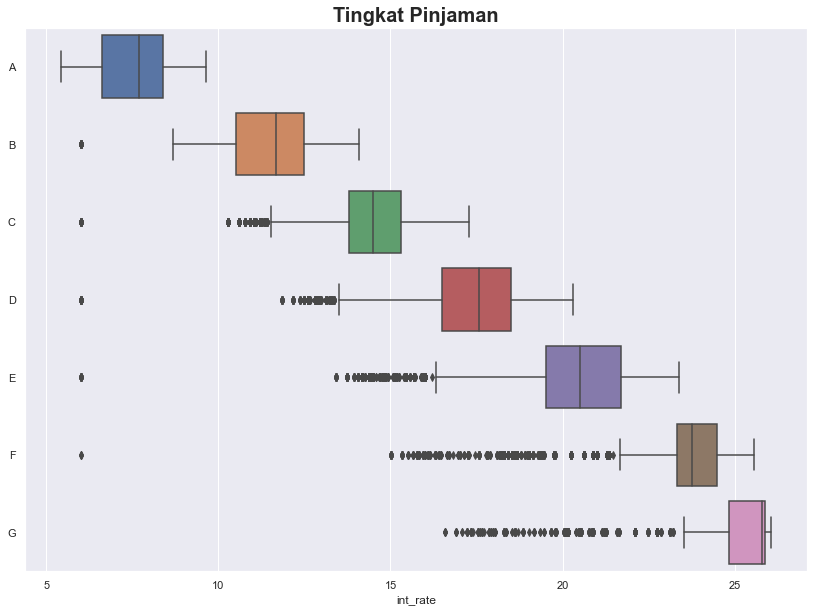

,count,mean,std,min,25%,50%,75%,max
grade,,,,,,,,
A,74867.0,7.538624,0.973636,5.42,6.62,7.69,8.39,9.63
B,136929.0,11.503253,1.294617,6.00,10.51,11.67,12.49,14.09
C,125293.0,14.634089,1.183195,6.00,13.79,14.49,15.31,17.27
D,76888.0,17.540598,1.385031,6.00,16.49,17.57,18.49,20.31
E,35757.0,20.487115,1.637443,6.00,19.52,20.50,21.70,23.40
F,13229.0,23.551352,1.716740,6.00,23.33,23.76,24.50,25.57
G,3322.0,24.838393,2.062895,16.59,24.83,25.80,25.89,26.06


In [242]:
x, y = "int_rate", "grade"
order = inter_df[y].sort_values().unique()
plot_boxplot(inter_df, x=x, y=y, title="Tingkat Pinjaman", order=order)
inter_df.groupby(y)[x].describe()

## Sub Tingkat Pinjaman
Pada tiap tingkatan pinjaman, terdapat sub bagian dari angka 1 sampai 5, semakin bisar angkanya maka semakin besar juga tingkat bunga pada tingkat tersebut.

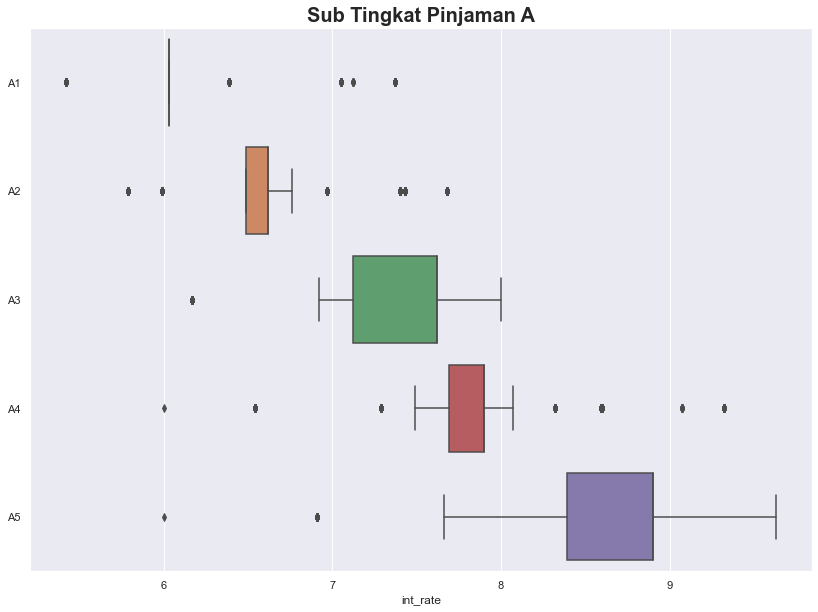

In [243]:
filter = inter_df["grade"] == "A"
order = inter_df.loc[filter, "sub_grade"].sort_values().unique()
plot_boxplot(inter_df, x="int_rate", y="sub_grade", title="Sub Tingkat Pinjaman A", order=order)

# Praproses Data

## Kolom Kategorikal

### Deteksi kolom bertipe objek

In [256]:
object_df = inter_df.select_dtypes(include=object).copy()

### Kolom yang berisikan tanggal
Format tanggal pada data ini adalah month-day, oleh karena itu kita akan mengubah format tersebut menjadi numerik supaya jumlah variabel tidak membludak ketika kita lakukan `one hot encode`.

In [257]:
date_cols = ["issue_d", "earliest_cr_line", "last_pymnt_d", "last_credit_pull_d", "next_pymnt_d"]

object_df[date_cols].head()

,issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d,next_pymnt_d
0,Dec-11,Jan-85,Jan-15,Jan-16,None
1,Dec-11,Apr-99,Apr-13,Sep-13,None
2,Dec-11,Nov-01,Jun-14,Jan-16,None
3,Dec-11,Feb-96,Jan-15,Jan-15,None
4,Dec-11,Jan-96,Jan-16,Jan-16,Feb-16


In [258]:
# Mencari semua nama bulan
unique_month = object_df["earliest_cr_line"].str.extract("(\w+)")[0].unique()
unique_month

array(['Jan', 'Apr', 'Nov', 'Feb', 'Jul', 'Sep', 'Oct', 'May', 'Aug',
       'Jun', 'Dec', 'Mar', nan], dtype=object)

In [78]:
# Membuat tabel kode bulan
month_code = {
    "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6,
    "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12
}

In [259]:
# Mengubah format tanggal menjadi numerik
def encode_date(date_string):
    if date_string is None or date_string is np.nan:
        return 0
    month, num = date_string.split("-")
    date_value = month_code[month] + int(num) / 100
    return date_value

encode_date("Aug-99")

8.99

In [260]:
# Terapkan pada semua kolom
for col in date_cols:
    object_df[col] = inter_df[col].apply(encode_date)

object_df[date_cols].head()

,issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d,next_pymnt_d
0,12.11,1.85,1.15,1.16,0.00
1,12.11,4.99,4.13,9.13,0.00
2,12.11,11.01,6.14,1.16,0.00
3,12.11,2.96,1.15,1.15,0.00
4,12.11,1.96,1.16,1.16,2.16


### Kolom yang seharusnya numerik
Terdapat kolom bertipe data objek yang juga memiliki nilai numerik di dalamnya. Pada kasus ini, kita cukup mengeluarkan angkanya.

#### emp_length

In [261]:
# Emp_length
emp_counts = inter_df["emp_length"].value_counts()
print(emp_counts)

## Ambil angka pada baris kolom
object_df["emp_length"] = inter_df["emp_length"].str.extract("(< \d+|\d+)")

## Ubah tahun menjadi angka
def year_to_num(value):
    if value is np.nan: 
        return value
    if "<" in value:
        return 0
    return int(value)

## Terapkan fungsi
object_df["emp_length"] = object_df["emp_length"].apply(year_to_num)
object_df["emp_length"]


10+ years    150049
2 years       41373
3 years       36596
< 1 year      36265
5 years       30774
1 year        29622
4 years       28023
7 years       26180
6 years       26112
8 years       22395
9 years       17888
Name: emp_length, dtype: int64


0         10.0
1          0.0
2         10.0
3         10.0
4          1.0
          ... 
466280     4.0
466281    10.0
466282     7.0
466283     3.0
466284    10.0
Name: emp_length, Length: 466285, dtype: float64

#### sub_grade

In [181]:
# Elemen Sub_grade
inter_df["sub_grade"].str.extract("([A-Z])")[0].unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G'], dtype=object)

In [197]:
# Sub_grade
grade_counts = inter_df["sub_grade"].value_counts()
print(grade_counts[:10])

# Tabel peringkat
grade_map = {"A": 7, "B": 6, "C": 5, "D": 4, "E": 3, "F": 2, "G": 1}

# Ubah peringkat menjadi angka
def grade_num(sub_grade):
    grade, num = sub_grade
    grade_value = grade_map[grade] + int(num) / 10
    return grade_value

## Terapkan fungsi
object_df["sub_grade"] = inter_df["sub_grade"].apply(grade_num)
object_df["sub_grade"]


B3    31686
B4    30505
C1    26953
C2    26740
B2    26610
C3    25317
B5    25252
C4    24105
B1    22876
C5    22178
Name: sub_grade, dtype: int64


0         6.2
1         5.4
2         5.5
3         5.1
4         6.5
         ... 
466280    5.2
466281    4.5
466282    4.1
466283    7.4
466284    4.3
Name: sub_grade, Length: 466285, dtype: float64

### Kolom yang seharusnya biner
Kolom biner memiliki jumlah kardinalitas sebesar 2. Mengetahui hal tersebut, kita bisa langsung mengganti kategori yang satu dengan angka 0 dan kategori satunya lagi dengan angka 1.

In [262]:
def one_hot_columns(df, colname):
    ohe = OneHotEncoder(drop="first")
    vector = df[colname].to_numpy().reshape(-1, 1)
    vector = ohe.fit_transform(vector).toarray()
    return vector, ohe

#### term

In [276]:
# Term
vector, ohe_term = one_hot_columns(inter_df, "term")

object_df["term"] = vector
object_df["term"].value_counts(), ohe_term.categories_

(0.0    337953
 1.0    128332
 Name: term, dtype: int64,
 [array([' 36 months', ' 60 months'], dtype=object)])

#### initial_list_status

In [275]:
# Initial_list_status
vector, ohe_init_list = one_hot_columns(inter_df, "initial_list_status")

object_df["initial_list_status"] = vector
object_df["initial_list_status"].value_counts(), ohe_init_list.categories_

(0.0    303005
 1.0    163280
 Name: initial_list_status, dtype: int64,
 [array(['f', 'w'], dtype=object)])

#### pyment_plan

In [274]:
# Payment_plan
vector, ohe_pyment = one_hot_columns(inter_df, "pymnt_plan")

object_df["pymnt_plan"] = vector
object_df["pymnt_plan"].value_counts(), ohe_pyment.categories_

(0.0    466276
 1.0         9
 Name: pymnt_plan, dtype: int64,
 [array(['n', 'y'], dtype=object)])

### Kolom yang berlebihan
Dua atau lebih kolom yang memberikan informasi yang mirip memberikan sedikit tingkat pembeda pada tiap barisnya. Oleh karena itu, kita perlu menghilangkan salah satunya.

#### grade dan sub_grade

In [266]:
inter_df[["grade", "sub_grade"]].head()

,grade,sub_grade
0,B,B2
1,C,C4
2,C,C5
3,C,C1
4,B,B5


In [267]:
del object_df["grade"]

#### title dan purpose

In [268]:
inter_df[["title", "purpose"]].head()

,title,purpose
0,Computer,credit_card
1,bike,car
2,real estate business,small_business
3,personel,other
4,Personal,other


In [269]:
del object_df["title"]

### Kolom yang tidak terpakai
Sisanya adalah kolom yang tidak terpakai, banyak alasan yang menyebabkan kolom tersebut tidak dipakai salah satunya adalah tingkat kardinalitas yang tinggi. Pada langkah ini kita akan mencari kolom yang sekiranya tidak memberikan informasi penting atau memberikan informasi yang kurang jelas.

#### zip_code
`zip_code` tidak begitu membantu karena 3 angka dibelakangnya disembunyikan. Kita sudah memiliki kolom yang merepresentasikan tempat yaitu `addr_state`, sehingga `zip_code` akan kita hapus.

In [291]:
inter_df["zip_code"].head()

0    860xx
1    309xx
2    606xx
3    917xx
4    972xx
Name: zip_code, dtype: object

In [270]:
del object_df["zip_code"]

#### emp_title
`emp_title` memiliki jumlah kardinalitas yang besarnya hampir setengah jumlah data, untuk menghindari resiko tingginya dimensi data, kita akan menghilangkan kolom ini.

In [292]:
inter_df["emp_title"].head()

0                        None
1                       Ryder
2                        None
3         AIR RESOURCES BOARD
4    University Medical Group
Name: emp_title, dtype: object

In [271]:
del object_df["emp_title"]

#### desc
`desc` merupakan kolom tekstual yang sebagian besar isinya sudah dijelaskan pada kolom-kolom yang lain, seperti tanggal peminjaman dan alasan meminjam.

In [290]:
inter_df["desc"].head()

0      Borrower added on 12/22/11 > I need to upgra...
1      Borrower added on 12/22/11 > I plan to use t...
2                                                 None
3      Borrower added on 12/21/11 > to pay for prop...
4      Borrower added on 12/21/11 > I plan on combi...
Name: desc, dtype: object

In [293]:
del object_df["desc"]

## Sisa Kolom Kategorikal
Kolom-kolom kategorikal yang tersisa akan dibiarkan dan nantinya akan digunakan sebagai prediktor.

In [294]:
cat_df = object_df.select_dtypes(include=object).copy()
cat_df

,sub_grade,home_ownership,verification_status,loan_status,purpose,addr_state
0,B2,RENT,Verified,Fully Paid,credit_card,AZ
1,C4,RENT,Source Verified,Charged Off,car,GA
2,C5,RENT,Not Verified,Fully Paid,small_business,IL
3,C1,RENT,Source Verified,Fully Paid,other,CA
4,B5,RENT,Source Verified,Current,other,OR
...,...,...,...,...,...,...
466280,C2,MORTGAGE,Source Verified,Current,debt_consolidation,TX
466281,D5,MORTGAGE,Verified,Charged Off,debt_consolidation,TN
466282,D1,MORTGAGE,Verified,Current,debt_consolidation,OH
466283,A4,OWN,Verified,Fully Paid,credit_card,CA


In [295]:
cat_df.nunique()

sub_grade              35
home_ownership          6
verification_status     3
loan_status             9
purpose                14
addr_state             50
dtype: int64

In [298]:
object_df[object_df["emp_length"].isna()]

,term,sub_grade,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d
168,0.0,A3,NaN,OWN,Source Verified,12.11,Charged Off,0.0,debt_consolidation,CA,8.94,0.0,12.13,0.0,1.16
323,1.0,D4,NaN,MORTGAGE,Verified,12.11,Fully Paid,0.0,debt_consolidation,AL,3.03,0.0,9.15,0.0,9.15
394,0.0,B3,NaN,RENT,Source Verified,12.11,Fully Paid,0.0,home_improvement,FL,2.05,0.0,5.12,0.0,5.12
422,0.0,C3,NaN,RENT,Not Verified,12.11,Charged Off,0.0,major_purchase,NJ,4.93,0.0,1.12,0.0,6.12
439,0.0,A3,NaN,MORTGAGE,Verified,12.11,Fully Paid,0.0,debt_consolidation,MD,12.81,0.0,12.14,0.0,12.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466254,1.0,E5,NaN,MORTGAGE,Source Verified,1.14,Charged Off,0.0,medical,GA,1.84,0.0,4.14,0.0,1.16
466256,0.0,D1,NaN,RENT,Source Verified,1.14,Charged Off,0.0,debt_consolidation,PA,4.01,0.0,11.14,0.0,1.16
466262,0.0,C5,NaN,MORTGAGE,Verified,1.14,Fully Paid,0.0,debt_consolidation,NJ,2.93,0.0,8.15,0.0,1.16
466265,0.0,A4,NaN,MORTGAGE,Source Verified,1.14,Fully Paid,0.0,major_purchase,CA,7.93,0.0,4.15,0.0,12.15


## Kolom Numerikal

In [245]:
num_df = inter_df.select_dtypes(include=["int", "float"]).copy()
num_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,5000,4975.0,10.65,162.87,24000.0,27.65,0.0,1.0,NaN,3.0,0.0,13648,83.7,9.0,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,171.62,0.0,0.0,NaN,NaN,NaN
1,2500,2500,2500.0,15.27,59.83,30000.0,1.00,0.0,5.0,NaN,3.0,0.0,1687,9.4,4.0,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,0.0,0.0,NaN,NaN,NaN
2,2400,2400,2400.0,15.96,84.33,12252.0,8.72,0.0,2.0,NaN,2.0,0.0,2956,98.5,10.0,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,649.91,0.0,0.0,NaN,NaN,NaN
3,10000,10000,10000.0,13.49,339.31,49200.0,20.00,0.0,1.0,35.0,10.0,0.0,5598,21.0,37.0,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,357.48,0.0,0.0,NaN,NaN,NaN
4,3000,3000,3000.0,12.69,67.79,80000.0,17.94,0.0,0.0,38.0,15.0,0.0,27783,53.9,38.0,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,67.79,0.0,0.0,NaN,NaN,NaN


### Imputasi Missing Value